# Recurrent Neural Nets in Tensorflow

Authors: Jeremy Locatelli, Erik Ring-Walters

## Introduction

In this project, we aimed to create a recurrent neural net in TensorFlow based on Andrej Karpathy's code in plain Python. This net reads a set of characters (Alice's Adventures in Wonderland, for example) and generates text that aims to look closer to the original text.

Here we test our neural net on a smaller dataset, but one with a much different style, every line from the hit movie starring Jerry Seinfeld, The Bee Movie. 

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.reset_default_graph()
plt.style.use('seaborn-whitegrid')

In [36]:
data = open('./beemovie.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

seq_length = 25

X = []
y = []

data has 52729 characters, 69 unique.


In [37]:
for i in range(0, len(data)-seq_length-1, 1):
        X.append([char_to_ix[ch] for ch in data[i:i+seq_length]])
        y.append([char_to_ix[ch] for ch in data[i+1:i+seq_length+1]])

# reshape the data
# in X_modified, each row is an encoded sequence of characters
X_modified = np.reshape(X, (len(X), seq_length))
y_modified = np.reshape(y, (len(y), seq_length))

In [38]:
# @params: X: the input array to fetch a batch from
# @params: y: the output array to fetch a corosponding batch from
# @params: batch_size: The size of the batch you want to pull
def fetchBatch(X,y,batch_size):
    idx = np.random.randint((len(X)-batch_size)-1)
    X_batch = X[idx:idx+batch_size,:]
    y_batch = y[idx:idx+batch_size,:]
    yield X_batch, y_batch

In [39]:
# Pulls a single random row from X_modifed
def single_batch(X):
    rnd = np.random.randint(len(X)-1)
    return X[rnd]

In [40]:
   
n_inputs = vocab_size
n_outputs = vocab_size
n_steps = 25
n_neurons = 100
tf.reset_default_graph()

## First problem we faced
One of the first big design decisions we made was whether to one hot encode each batch in tensorflow, or one hot encode the entire input text, then create batches with that. We decided to one hot encode each batch because we had trouble creating a fetch batch function on the large one hot encoded 3D array.

In [41]:
X = tf.placeholder(tf.int32, [None, n_steps])
one_hot_X = tf.one_hot(X, vocab_size)
y = tf.placeholder(tf.int32, [None, n_steps])
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(
        num_units=n_neurons, activation=tf.nn.relu),output_size=n_outputs)

cpu_gru_cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUBlockCellV2(
        num_units=n_neurons),output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, one_hot_X, dtype=tf.float32) 
learning_rate = 0.001
y_probs = tf.nn.softmax(logits=outputs)
xenthropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=outputs, labels=y)
loss = tf.reduce_mean(xenthropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)


## Sampling data
#### Thanks Dr. Bruns
This was the biggest breakthrough in terms of understanding, creating a "floating window" that tracked the updated sequence we feed to the RNN. Once we got this working it led to the discovery of several other issues. 
One was for some reason all of our outputs were converging towards a single character, e.g. i would call sample with length 100 and it would output 100 commas (or newline characters which does wonders for a console program..)
I tried to solve this bug for hours, looking at the probability distributions for sequential predictions. Then we discovered in our fetch batch function, we accidentaly assigned both X and y_batch to the same values. Once we fixed that one character error, our output started to improve. 

In [42]:
def sample(seed_pred, n):
    start_idx = 0
    # list of indexes we predict
    output = []
    # Debug for seeing the prob distributions
    probs_list = []
    
    for i in range(n):
      # This creates the moving window that starts with our input sequence, and the new input is appended at each loop
      window = seed_pred[start_idx:start_idx + n_steps]
      # We then rotate it to batch_size = 1 and 25 cols for entry into the X tensor
      window = window.reshape((1, n_steps))
      # We evaluate the softmax of the outputs by inserting our array window into the network and getting the logits
      char_prob = y_probs.eval(feed_dict={X:window})
      probs_list.append(char_prob)
      # We only care about the last character softmaxed outputs, as this is the probability of a choice of one of len(vocab_size) characters
      last_char = char_prob[0][n_steps-1]
      # We get an index value by pulling a random value /according to the probabilty distribution of the last_chars softmax      
      ind = np.random.choice(range(vocab_size), p=last_char.ravel())
      # tack that onto our big list
      output.append(ind)
      # reshape ind so we can tack it to the bottom of seed_pred
      ind = ind.reshape((1,))
      # append it to seed_pred
      seed_pred = np.append(seed_pred, ind, axis=0)
      # move the window up one and continue
      start_idx +=1
    return output, probs_list

In [43]:
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 50
basic_losses = []
with tf.Session() as sess:
    init.run()
    print("===Basic Cell RNN===")
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetchBatch(X_modified,y_modified,batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if epoch % 250 == 0:
                cur_loss = loss.eval(feed_dict={X:X_batch, y:y_batch})
                basic_losses.append(cur_loss)
                print(f"Current epoch: {epoch} \tLoss: \t{cur_loss}\n")
                solo_batch = single_batch(X_modified)
                smpl, _ = sample(solo_batch,100)
                txt = ''.join(ix_to_char[ix] for ix in smpl)
                print("OUTPUT")
                print('===============\n %s \n===============' % (txt, ))

===Basic Cell RNN===
Current epoch: 0 	Loss: 	4.194098472595215

OUTPUT
 fqd
JIO!'b3L6e9Rg61JbWx0?zod!fQqG'"6uLpF41,fwSfujGKf:MlS:, .Fd1Q
HcP'2q067qgSrk:Egjjr-aDDHwG-fMD"B!P 
Current epoch: 2500 	Loss: 	2.0627481937408447

OUTPUT
  wat ia lesem thet wos? Whare ghe king.

 Nod youphntew shalk ar eass, yould taking in got on thing  
Current epoch: 5000 	Loss: 	2.2492544651031494

OUTPUT
 yw.

 Yelaalild gat fiscarnound thecking coplong,

 wish everom fud in yrione! And ores, legingcis t 
Current epoch: 7500 	Loss: 	1.8409218788146973

OUTPUT
 y wis tian to cours!

 I'm right up you met wn this!

 Bresine adee all itrlabe an? Ana sie to say t 


# GRU RNN
Here we build a RNN with the exact same architecture as the last one, but we use GRU Cells instead of basic RNN cells.

In [44]:
tf.reset_default_graph() 
X = tf.placeholder(tf.int32, [None, n_steps])
one_hot_X = tf.one_hot(X, vocab_size)
y = tf.placeholder(tf.int32, [None, n_steps])

cpu_gru_cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUBlockCellV2(
        num_units=n_neurons),output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cpu_gru_cell, one_hot_X, dtype=tf.float32) 
learning_rate = 0.001
y_probs = tf.nn.softmax(logits=outputs)
xenthropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=outputs, labels=y)
loss = tf.reduce_mean(xenthropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [45]:
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 50
lstm_losses = []
with tf.Session() as sess:
    init.run()
    print("===GRU RNN===")
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetchBatch(X_modified,y_modified,batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if epoch % 250 == 0:
                cur_loss = loss.eval(feed_dict={X:X_batch, y:y_batch})
                lstm_losses.append(cur_loss)
                print(f"Current epoch: {epoch} \tLoss: \t{cur_loss}\n")
                solo_batch = single_batch(X_modified)
                smpl, _ = sample(solo_batch,100)
                txt = ''.join(ix_to_char[ix] for ix in smpl)
                print("OUTPUT")
                print('===============\n %s \n===============' % (txt, ))
                
                    

===GRU RNN===
Current epoch: 0 	Loss: 	4.198111057281494

OUTPUT
 7QHPuyNHE3
:M5M8Lou,bgmRNfxO N:PE1
VtddQnh3pf37skF.ISgt.M-9lhwTqL47ryjRzftf
p,v" a-9WqVzKsA',GUWIyg5 
Current epoch: 2500 	Loss: 	1.9203094244003296

OUTPUT
 t.
. - pell.

 - Nol.

 Barem. Io Orore seandysne I donyte cKut, steces a lid.

 You dor yeallthe bc 
Current epoch: 5000 	Loss: 	1.3278095722198486

OUTPUT
 s. You'se got if recphyther this is!

 He.

 Your fore it keol packnom theter asling her thm woren.  
Current epoch: 7500 	Loss: 	1.8070523738861084

OUTPUT
 k lifter!

 So.

 Bet, I'd a joithit of have is ceaple a bel you out I gock it we ron't it, the Bair 


# LSTM RNN

Finally, we build a LSTM cell rather than a GRU cell.

In [46]:
tf.reset_default_graph() 
X = tf.placeholder(tf.int32, [None, n_steps])
one_hot_X = tf.one_hot(X, vocab_size)
y = tf.placeholder(tf.int32, [None, n_steps])

cpu_lstm_cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GLSTMCell(
        num_units=n_neurons),output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cpu_lstm_cell, one_hot_X, dtype=tf.float32) 
learning_rate = 0.001
y_probs = tf.nn.softmax(logits=outputs)
xenthropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=outputs, labels=y)
loss = tf.reduce_mean(xenthropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [47]:
init = tf.global_variables_initializer()

n_epochs = 10000
batch_size = 50
lstm_losses = []
with tf.Session() as sess:
    init.run()
    print("===LSTM RNN===")
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetchBatch(X_modified,y_modified,batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if epoch % 2500 == 0:
                cur_loss = loss.eval(feed_dict={X:X_batch, y:y_batch})
                lstm_losses.append(cur_loss)
                print(f"Current epoch: {epoch} \tLoss: \t{cur_loss}\n")
                solo_batch = single_batch(X_modified)
                smpl, _ = sample(solo_batch,100)
                txt = ''.join(ix_to_char[ix] for ix in smpl)
                print("OUTPUT")
                print('===============\n %s \n===============' % (txt, ))
                

===LSTM RNN===
Current epoch: 0 	Loss: 	4.221384048461914

OUTPUT
 ErnMa-USvk
G0"M.o!x:hr.T4cOs-4K6p,5vvHLEM8L4jPkFJjok.SF7xdNJjPnqA?T9.TGx9pc!Q.OVgNifWDRdd2ju-pq-zU!Q 
Current epoch: 2500 	Loss: 	1.844819188117981

OUTPUT
 k. Bearasi wors, theld hot!

 Ar mith.

 Yar aan fiikn't a aall youree nous.

 Siet w ma foongtre or 
Current epoch: 5000 	Loss: 	1.8325810432434082

OUTPUT
  enay we way whikke to bon'm dofre to you'de tneak righ.

 Tilpser, crrenneopest hat uh une the rove 
Current epoch: 7500 	Loss: 	1.500920057296753

OUTPUT
 s it a beee here.

 Shele, caictmer! - I'm alc palpser, my we inuss what thore gor" well halp nimd c 


init = tf.global_variables_initializer()

n_epochs = 10000
batch_size = 50
gru_losses = []
with tf.Session() as sess:
    init.run()
    print("===LSTM RNN===")
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetchBatch(X_modified,y_modified,batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if epoch % 1000 == 0:
                cur_loss = loss.eval(feed_dict={X:X_batch, y:y_batch})
                gru_losses.append(cur_loss)
                print(f"Current epoch: {epoch} \tLoss: \t{cur_loss}\n")
                solo_batch = single_batch(X_modified)
                smpl, _ = sample(solo_batch,100)
                txt = ''.join(ix_to_char[ix] for ix in smpl)
                print("OUTPUT")
                print('===============\n %s \n===============' % (txt, ))

Text(0,0.5,'output iteration')

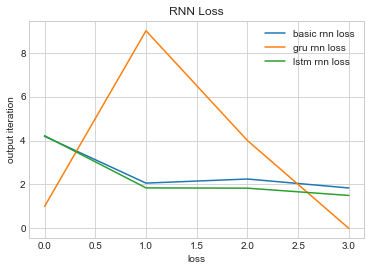

In [52]:
x= np.arange(len(basic_losses))
plt.plot(x,basic_losses, label='basic rnn loss')
plt.plot(x,gru_losses, label='gru rnn loss')
plt.plot(x,lstm_losses, label='lstm rnn loss')
plt.legend();
plt.title("RNN Loss")
plt.xlabel("loss")
plt.ylabel("output iteration")

## Conclusion

In this report, we explored recurrent neural nets in TensorFlow. Using Karpathy's plain Python code as a baseline, we were able to create functioning neural nets that used "The Bee Movie's" script as input and output pieces of text that looked somewhat like movie script lines. The most difficult challenges we faced included understanding the geometry and proper dimensions of our data structures to properly work with our data, as well as ensuring our TensorFlow code was implementing proper variables when needed.